# Convolution Neural Network

Fully-Connected Neural Networks for image
recognition/classification:
1. Dimension Problem:

  • Reshaping to 1D: loosing the spatial structure
2. Size Problem:

  • Example features: 1000 × 1000 × 3 [Y × X × RGB]

  • Weights: 3M for each neuron just for first layer

  • 100 layers: about 300M DP weights => 2.4GB model
size

3. Overfitting problem:

  • One weight per pixel leads to overfitting

### CNN in Tensorflow

---

LeNet

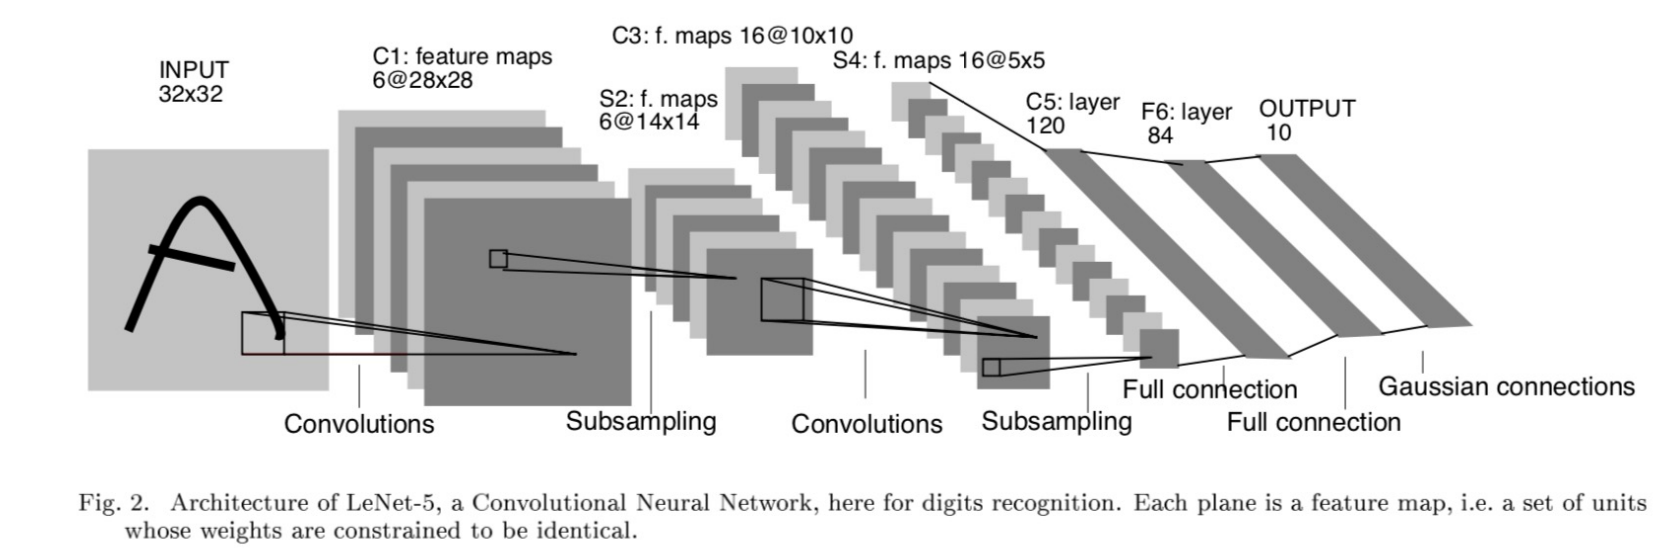

In [ ]:
from tensorflow.keras import datasets, layers, models, losses

def create_model():
  model = models.Sequential()

  model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=x_train.shape[1:]))
  model.add(layers.AveragePooling2D(2))


  model.add(layers.Conv2D(16, 5, activation='tanh'))
  model.add(layers.AveragePooling2D(2))


  model.add(layers.Conv2D(120, 5, activation='tanh'))

  model.add(layers.Flatten())
  model.add(layers.Dense(84, activation='tanh'))

  model.add(layers.Dense(10, activation='softmax'))

  return model



#### Training CNN with Model Checkpointing

Loading CIFAR-10 dataset

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()
print("X_train shape:", x_train.shape)


170498071/170498071 [==============================] - 14s 0us/step
X_train shape: (50000, 32, 32, 3)


Defining Checkpoint function and Printing Callback class

In [ ]:

# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)


# defining a function to checkpoint the model

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)



Training model

In [ ]:
#model creation, compilation and training

model = create_model()
optim = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size=512,
    epochs=5,
    verbose=0,
    callbacks=[PrintingCallback(), model_checkpoint_callback],
)


The average loss for epoch 0 is    1.63 and accuracy is    0.42.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.42240, saving model to ./tmp/checkpoint
The average loss for epoch 1 is    1.54 and accuracy is    0.45.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.42240 to 0.44990, saving model to ./tmp/checkpoint
The average loss for epoch 2 is    1.49 and accuracy is    0.47.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.44990 to 0.46520, saving model to ./tmp/checkpoint
The average loss for epoch 3 is    1.46 and accuracy is    0.48.
LR is: 0.001

Epoch 4: val_accuracy improved from 0.46520 to 0.48140, saving model to ./tmp/checkpoint
The average loss for epoch 4 is    1.40 and accuracy is    0.50.
LR is: 0.001

Epoch 5: val_accuracy improved from 0.48140 to 0.50150, saving model to ./tmp/checkpoint


We will now load the model using the saved file. Let's change the learning rate to 0.0001 and train the model for 10 more epochs.

In [ ]:
model.load_weights(checkpoint_filepath)
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    batch_size=512,
    epochs=10,
    verbose=0,
    callbacks=[PrintingCallback(), model_checkpoint_callback],
)

The average loss for epoch 0 is    1.40 and accuracy is    0.50.
LR is: 0.001

Epoch 1: val_accuracy improved from 0.50150 to 0.50350, saving model to ./tmp/checkpoint
The average loss for epoch 1 is    1.37 and accuracy is    0.51.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.50350 to 0.51430, saving model to ./tmp/checkpoint
The average loss for epoch 2 is    1.33 and accuracy is    0.53.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.51430 to 0.52660, saving model to ./tmp/checkpoint
The average loss for epoch 3 is    1.35 and accuracy is    0.52.
LR is: 0.001

Epoch 4: val_accuracy did not improve from 0.52660
The average loss for epoch 4 is    1.31 and accuracy is    0.54.
LR is: 0.001

Epoch 5: val_accuracy improved from 0.52660 to 0.53710, saving model to ./tmp/checkpoint
The average loss for epoch 5 is    1.31 and accuracy is    0.54.
LR is: 0.001

Epoch 6: val_accuracy did not improve from 0.53710
The average loss for epoch 6 is    1.30 and accuracy is    0.54.
LR 

### CNN in PyTorch

---

In [ ]:
import torch.nn as nn

def create_model():
    model = nn.Sequential(
        nn.Conv2d(3, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(576, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

#### Training CNN with Model Checkpointing

Loading CIFAR-10 dataset

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


Defining Train function with checkpoint functionality and  printing information during training

In [ ]:

def train_model(start,epochs, model):
  train_losses = []
  test_losses = []
  train_accs = []
  test_accs  = []
  for i in range(start, start + epochs):
      trn_corr = 0
      tst_corr = 0
      batch_corr = 0

      for X_train, y_train in train_loader:

        X_train, y_train = X_train.to(device), y_train.to(device)


        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      accuracy = trn_corr.item() / (len(train_dataset))

      train_losses.append(loss)
      train_accs.append(accuracy)


      with torch.no_grad():

        for X_test, y_test in test_loader:

          X_test, y_test = X_test.to(device), y_test.to(device)

          y_val = model(X_test)

          predicted = torch.max(y_val.data, 1)[1]
          tst_corr += (predicted == y_test).sum()

      test_accuracy = tst_corr.item() / (len(test_dataset))

      val_loss = criterion(y_val,y_test)
      test_losses.append(val_loss)

      test_accs.append(test_accuracy)
      print( f'epoch: {i} training loss:{loss.item()} training accuracy:{accuracy} val loss:{val_loss.item()} val accuracy:{test_accuracy}')

      for param_group in optimizer.param_groups:
        print('lr', param_group['lr'])

      torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, PATH)


Training model

In [ ]:

PATH = "model_10.pt"

model = create_model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_model(0,10,model)

epoch: 0 training loss:1.7728254795074463 training accuracy:0.31396 val loss:1.6136208772659302 val accuracy:0.4053
lr 0.001
epoch: 1 training loss:1.488530158996582 training accuracy:0.4246 val loss:1.5658503770828247 val accuracy:0.4507
lr 0.001
epoch: 2 training loss:1.4680039882659912 training accuracy:0.46232 val loss:1.4729082584381104 val accuracy:0.4903
lr 0.001
epoch: 3 training loss:1.2452014684677124 training accuracy:0.4921 val loss:1.4123320579528809 val accuracy:0.5134
lr 0.001
epoch: 4 training loss:1.3842042684555054 training accuracy:0.51612 val loss:1.3721908330917358 val accuracy:0.5203
lr 0.001
epoch: 5 training loss:1.2730841636657715 training accuracy:0.53648 val loss:1.340599536895752 val accuracy:0.5385
lr 0.001
epoch: 6 training loss:1.2363865375518799 training accuracy:0.55314 val loss:1.3251752853393555 val accuracy:0.5455
lr 0.001
epoch: 7 training loss:1.198891520500183 training accuracy:0.5688 val loss:1.2961043119430542 val accuracy:0.5594
lr 0.001
epoch:

We will now load the model using the saved file. Let's change the learning rate to 0.0001 and train the model for 10 more epochs.

In [ ]:
model = create_model().to(device)
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for g in optimizer.param_groups:
    g['lr'] = 0.001
epoch = checkpoint['epoch']
loss = checkpoint['loss']

train_model(epoch, 10,model.train())

epoch: 9 training loss:0.9879193902015686 training accuracy:0.61054 val loss:1.2543987035751343 val accuracy:0.5856
lr 0.001
epoch: 10 training loss:1.0249114036560059 training accuracy:0.61932 val loss:1.2083712816238403 val accuracy:0.5903
lr 0.001
epoch: 11 training loss:1.0450700521469116 training accuracy:0.6284 val loss:1.1831433773040771 val accuracy:0.5981
lr 0.001
epoch: 12 training loss:1.1585239171981812 training accuracy:0.63962 val loss:1.201728343963623 val accuracy:0.5917
lr 0.001
epoch: 13 training loss:1.2283536195755005 training accuracy:0.64748 val loss:1.246360182762146 val accuracy:0.5873
lr 0.001
epoch: 14 training loss:1.0729628801345825 training accuracy:0.65342 val loss:1.1822832822799683 val accuracy:0.6062
lr 0.001
epoch: 15 training loss:0.9973289370536804 training accuracy:0.6615 val loss:1.2019435167312622 val accuracy:0.5996
lr 0.001
epoch: 16 training loss:0.9532753825187683 training accuracy:0.66948 val loss:1.1885457038879395 val accuracy:0.6059
lr 0.0

### AlexNet
---

 - Seminal Paper for CNNs in 2012
 - Introduced ReLU
 - Introduced Dropout
 - Introduced overlap pooling (stride < filter size)
 - Basically one of the most influential papers in CV with 80K+ citations

In [ ]:
from IPython.display import Image
Image(url='https://cdn.jsdelivr.net/gh/MakeSchool-Tutorials/Keras-for-Image-Classification@master/P03-Building-a-Keras-Sequential-Model/assets/cnn-fletcher-bach.gif')

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, concatenate, Add, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


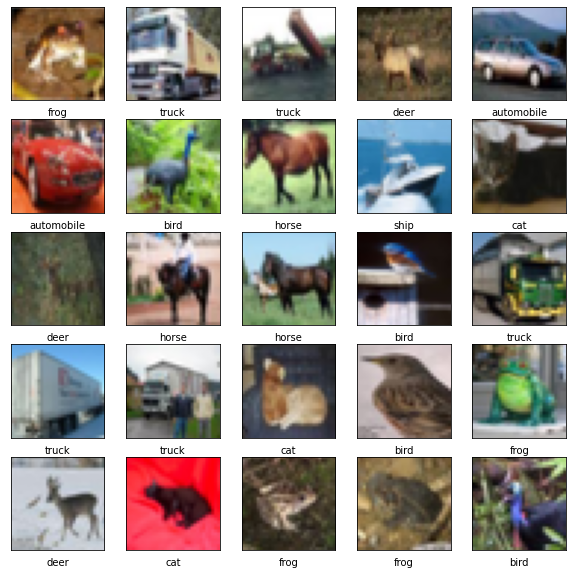

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_images.shape[0])
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=test_images.shape[0])
                  .batch(batch_size=32, drop_remainder=True))

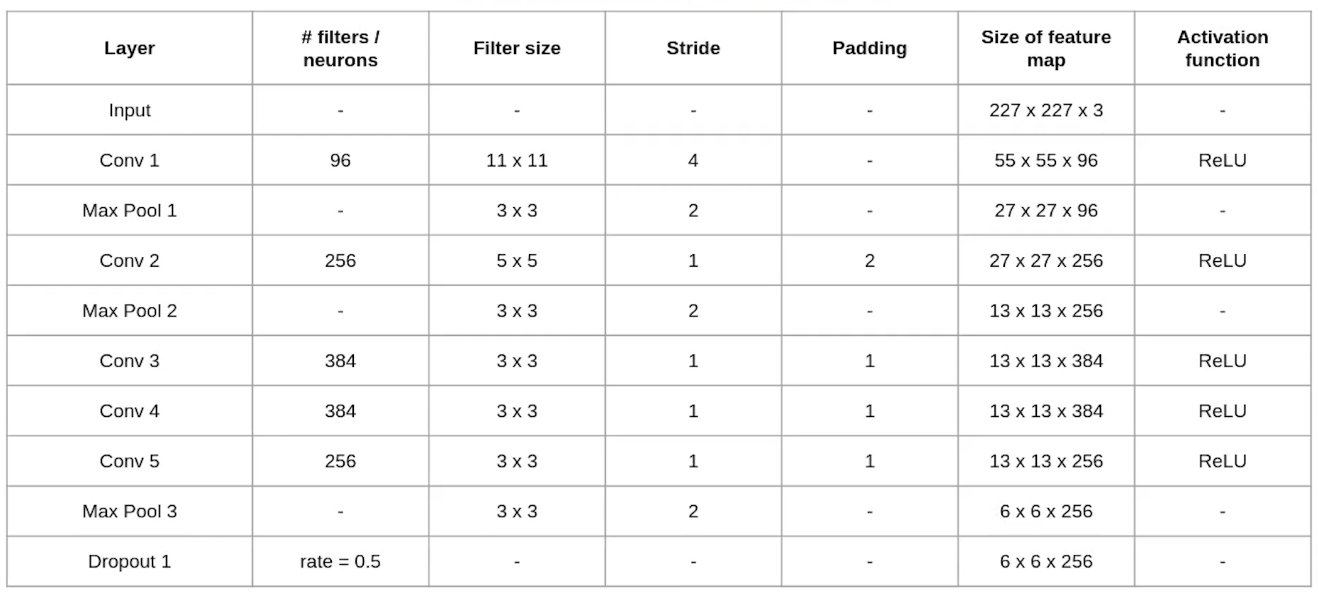

In [ ]:
alexnet = models.Sequential([
    # Conv 1
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=4, activation='relu', input_shape=(227,227,3)),
    layers.BatchNormalization(),

    # Max Pool 1
    layers.MaxPool2D(pool_size=(3,3), strides=2),

    # Conv 2
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=1, activation='relu', padding="same"),
    layers.BatchNormalization(),

    # Max Pool 2
    layers.MaxPool2D(pool_size=(3,3), strides=2),

    # Conv 3
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=1, activation='relu', padding="same"),
    layers.BatchNormalization(),

    # Conv 4
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=1, activation='relu', padding="same"),
    layers.BatchNormalization(),

    # Conv 5
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=2, activation='relu', padding="same"),
    layers.BatchNormalization(),

    # Max Pool 3
    layers.MaxPool2D(pool_size=(3,3), strides=2),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [ ]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
alexnet.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = alexnet.fit(train_ds, epochs=2, batch_size=1,
                    validation_data=test_ds)

Epoch 1/2
